In [1]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import random
import scipy

# Hopfield Network

## What is a Hopfield Network?
It is a model of how neurons store and process memories. We will learn how to implement this model, teach it to memorize images, and recover images from its memory.

In general, a neural network is a graph with neurons at the vertices of the graph and edges connecting the neurons to one another. The edges of this graph can be directed or undirected. The Hopfield network in particular has undirected edges. The Hopfield network has a set of variables that define the model. Each neuron $n$ has a state $s_n$, representing the magnitude by which the neuron is "activated" the level of activation of the neuron. Each neuron also has a threshold (bias) $b_n$ to activate and each edge has a weight $W_{nm}$ associated with it that indicates how likely neurons, $n$ and $m$ are to activate together.

The dynamics of this network are governed by an update rule. At a step $a$, we choose any random neuron, $n$, to update. The state of the $n^{th}$ neuron $s^a_n$ is either 1 or -1. To decide on the new state at step $a$ + 1, we:
* ignore the current neuron's state:
* compute the total “weight” coming into it, $T_n$ = $\sum_{m \neq n}$ $s^a_m$ $W_{mn}$
* if $T_n$ < $b_n$, new state $s^{a+1}_n$ = -1, else $s^{a+1}_n$ = 1

In [2]:
def initialize_network(n):
    state = np.random.choice([-1, 1], (n,))
    biases = np.random.uniform(-1, 1, (n,))
    weights = np.random.uniform(-1, 1, (n, n))
    weights = (weights + weights.T) / 2
    np.fill_diagonal(weights, 0)
    return state, biases, weights

In [3]:
def energy(state, biases, weights):
    E = -0.5 * np.sum(weights * np.outer(state, state)) + np.sum(state * biases)
    return E

In [4]:
def update(s, b, w, idx):
    net_input = np.dot(w[idx], s) + b[idx]
    if s[idx] * net_input < 0:
        s[idx] *= -1

Now we will verify the statement that the energy never increases during a Hopfield network’s dynamics. In order to do this, we will run our network through the update rule for a series of random initial states. Measure the energy of the initial states and their subsequent updates. Then we will produce a graph, with lines for each run, plotting the energy versus update step. 

In [5]:
num_neurons = 100
num_runs = 10
sweeps = 50

energy_list = np.zeros((num_runs, sweeps))
for run in range(num_runs):
    state, biases, weights = initialize_network(num_neurons)
    energies = np.zeros(sweeps)
    for sweep in range(sweeps):
        flip_idx = np.random.randint(0, num_neurons, size=num_neurons)
        for idx in flip_idx:
            update(state, biases, weights, idx)
        energies[sweep] = energy(state, biases, weights)
    
    energy_list[run, :] = energies

Text(0, 0.5, 'Energy')

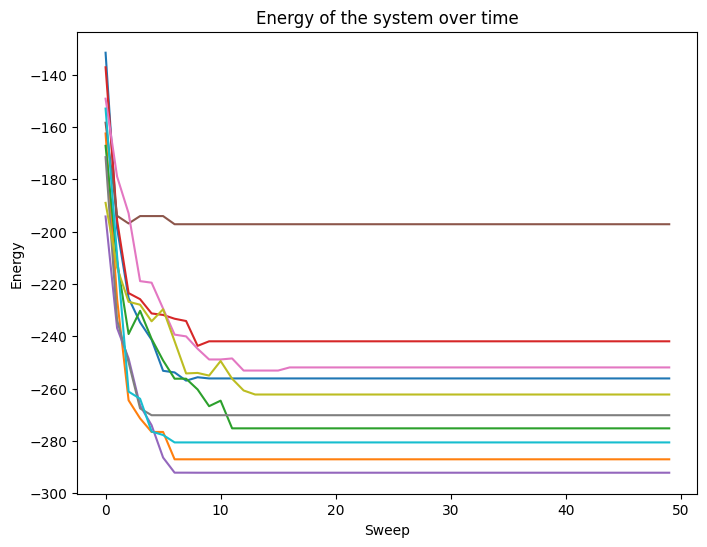

In [6]:
plt.figure(figsize=(8, 6))
for energies in energy_list:
    plt.plot(range(sweeps), energies)
plt.title("Energy of the system over time")
plt.xlabel("Sweep")
plt.ylabel("Energy")

We observe that the plots are monotonically non-increasing. This demonstrates that Hopfield networks converge to some “memory” for different initial conditions.

# Input Training

Now we will train our network on some pixelated images of a "face" and "tree" and see how well it can remember and reconstruct it

Binary representation of the face image:
0000000000000100010000000000000000000000000010000000000000000001110000001000100001000001101000000001


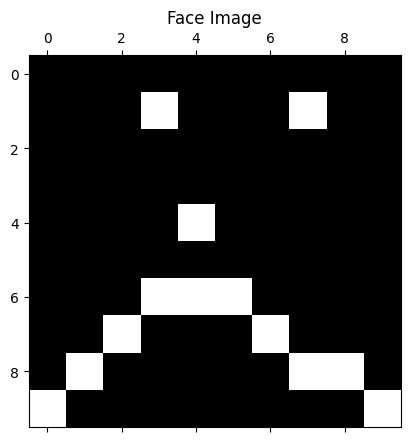

In [7]:
#Code for the face and tree images
def PrintImageNumber(a):
    for i in np.ndarray.flatten(a):
        print(i,end='')
    print()

def MakeFace():
    face=np.zeros((10,10),int)
    face[9,0]=1
    face[8,1]=1
    face[7,2]=1
    face[6,3]=1
    face[6,4]=1
    face[6,5]=1
    face[7,6]=1
    face[8,7]=1
    face[8,8]=1
    face[9,9]=1
    face[1,3]=1
    face[1,7]=1
    face[4,4]=1
    return face

def MakeTree():
    tree=np.zeros((10,10),int)
    for i in range(0,10):
        tree[i,4]=1
        tree[i,5]=1
    for i in range(3,7):
        tree[1,i]=1
        tree[0,i]=1

    for i in range(2,9):
        tree[4,i]=1
    tree[5,8]=1
    return tree

face = MakeFace()
plt.matshow(face, cmap='gray')
plt.title("Face Image")


print("Binary representation of the face image:")
PrintImageNumber(face)


Binary representation of the tree image:
0001111000000111100000001100000000110000001111111000001100100000110000000011000000001100000000110000


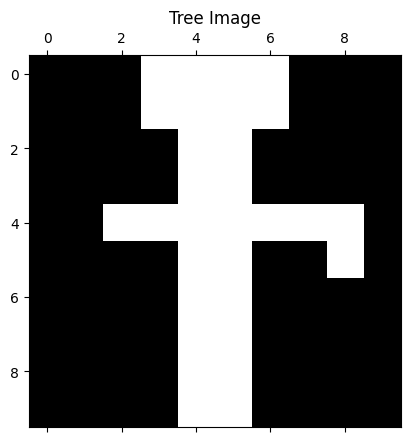

In [8]:
tree = MakeTree()
plt.matshow(tree, cmap='gray')
plt.title("Tree Image")

print("Binary representation of the tree image:")
PrintImageNumber(tree)

In [9]:
def memorization_network(patterns):
    if not patterns:
        return np.zeros((0,0)), np.zeros((0,))
    n = patterns[0].size

    weights = np.zeros((n, n))
    biases = np.zeros(n)

    for v in patterns:
        v = v.reshape(-1)         
        weights += np.outer(v, v)       

    weights /= len(patterns)
    np.fill_diagonal(weights, 0)

    return weights, biases

Weights:
0.01.01.00.00.00.00.01.01.01.01.01.01.0-1.00.00.00.00.01.01.01.01.01.01.00.00.01.01.01.01.01.01.01.01.00.00.01.01.01.01.01.01.00.00.0-1.00.00.00.00.01.01.01.01.01.00.00.01.01.00.01.01.01.01.00.0-1.0-1.01.01.01.01.01.01.00.01.00.00.00.01.01.01.01.00.01.01.00.00.01.00.00.01.00.01.01.01.00.00.01.01.01.00.01.00.01.00.00.00.00.01.01.01.01.01.01.0-1.00.00.00.00.01.01.01.01.01.01.00.00.01.01.01.01.01.01.01.01.00.00.01.01.01.01.01.01.00.00.0-1.00.00.00.00.01.01.01.01.01.00.00.01.01.00.01.01.01.01.00.0-1.0-1.01.01.01.01.01.01.00.01.00.00.00.01.01.01.01.00.01.01.00.00.01.00.00.01.00.01.01.01.00.00.01.01.01.00.01.01.00.00.00.00.00.01.01.01.01.01.01.0-1.00.00.00.00.01.01.01.01.01.01.00.00.01.01.01.01.01.01.01.01.00.00.01.01.01.01.01.01.00.00.0-1.00.00.00.00.01.01.01.01.01.00.00.01.01.00.01.01.01.01.00.0-1.0-1.01.01.01.01.01.01.00.01.00.00.00.01.01.01.01.00.01.01.00.00.01.00.00.01.00.01.01.01.00.00.01.01.01.00.00.00.00.00.01.01.01.00.00.00.00.00.00.00.01.01.01.0-1.00.00.00.00.00.00.01.01.0

Text(0.5, 1.0, 'Corrupted Tree Image')

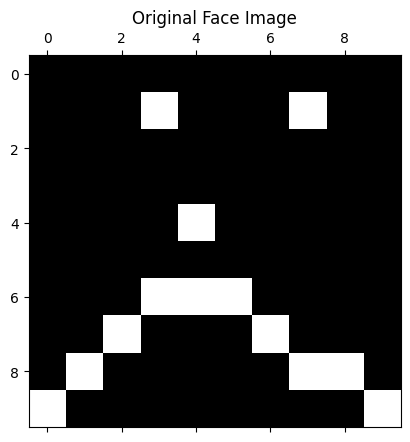

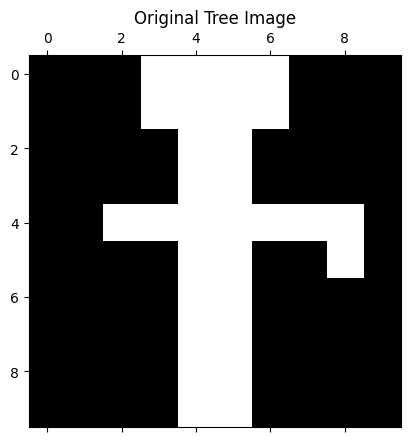

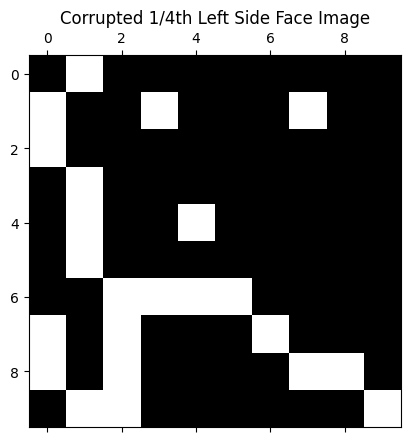

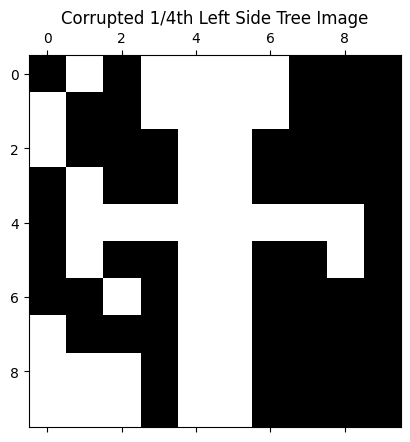

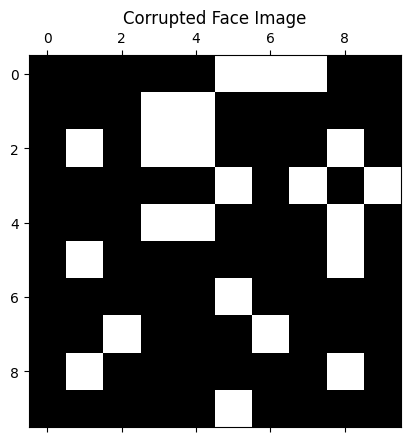

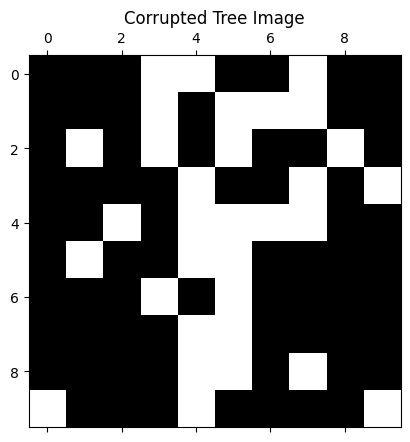

In [10]:
#Corrupt Images
np.random.seed(446)

face_copy = face.copy()
tree_copy = tree.copy()

#showing original images
for i in range(10):
  for j in range(10):
    if tree_copy[i, j] == 0:
      tree_copy[i, j] = -1
    if face_copy[i,j] == 0:
      face_copy[i,j] = -1
plt.matshow(face_copy, cmap='gray')
plt.title("Original Face Image")
plt.matshow(tree_copy, cmap='gray')
plt.title("Original Tree Image")

weights, biases = memorization_network([face_copy.reshape((-1, 1)), tree_copy.reshape((-1, 1))])
print("Weights:")
PrintImageNumber(weights)
print("Biases:")
PrintImageNumber(biases)


#Left 1/4th Corruption
left_face_corrupted = face_copy.copy()
left_tree_corrupted = tree_copy.copy()

for i in range(10):
  for j in range(3):
    if np.random.rand() < 0.5:
      left_face_corrupted[i, j] *= -1
      left_tree_corrupted[i, j] *= -1

  
plt.matshow(left_face_corrupted, cmap='gray')
plt.title("Corrupted 1/4th Left Side Face Image")
plt.matshow(left_tree_corrupted, cmap='gray')
plt.title("Corrupted 1/4th Left Side Tree Image")


#corrupting k spots
k = 30
k_corrupted_face = face_copy.copy()
k_corrupted_tree = tree_copy.copy()
for i in range(k):
  x = random.randint(0, 9)
  y = random.randint(0, 9)
  k_corrupted_face[x, y] *= -1
  k_corrupted_tree[x, y] *= -1
plt.matshow(k_corrupted_face, cmap='gray')
plt.title("Corrupted Face Image")
plt.matshow(k_corrupted_tree, cmap='gray')
plt.title("Corrupted Tree Image")

### Retrieving original images

-1-1-1-1-1-1-1-1-1-1-1-1-11-1-1-11-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-11-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1111-1-1-1-1-1-11-1-1-11-1-1-1-11-1-1-1-1-111-11-1-1-1-1-1-1-1-11


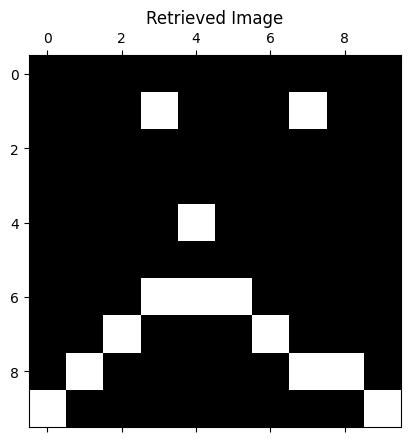

-1-1-11111-1-1-1-1-1-11111-1-1-1-1-1-1-111-1-1-1-1-1-1-1-111-1-1-1-1-1-11111111-1-1-1-1-111-1-11-1-1-1-1-111-1-1-1-1-1-1-1-111-1-1-1-1-1-1-1-111-1-1-1-1-1-1-1-111-1-1-1-1


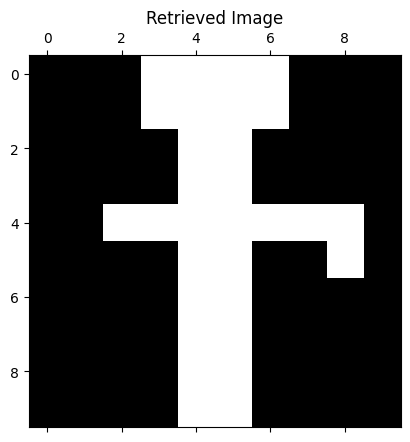

-1-1-1-1-1-1-1-1-1-1-1-1-11-1-1-11-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-11-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1111-1-1-1-1-1-11-1-1-11-1-1-1-11-1-1-1-1-111-11-1-1-1-1-1-1-1-11


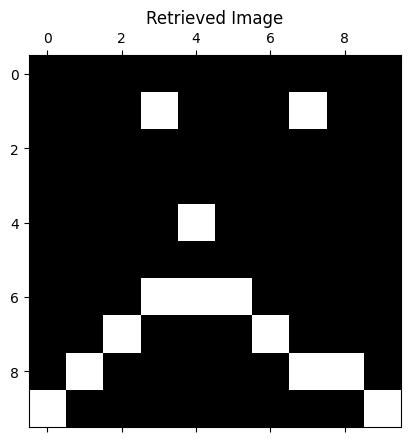

-1-1-11111-1-1-1-1-1-11111-1-1-1-1-1-1-111-1-1-1-1-1-1-1-111-1-1-1-1-1-11111111-1-1-1-1-111-1-11-1-1-1-1-111-1-1-1-1-1-1-1-111-1-1-1-1-1-1-1-111-1-1-1-1-1-1-1-111-1-1-1-1


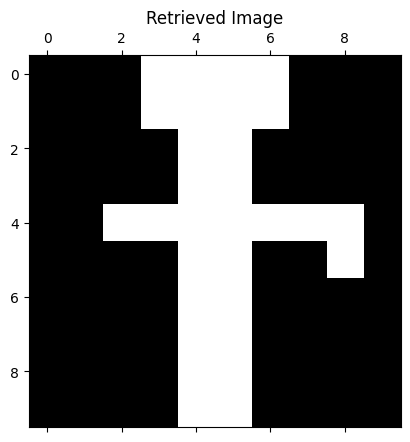

In [ ]:
corrupted_images = [left_face_corrupted.reshape((-1, 1)), left_tree_corrupted.reshape((-1, 1)), k_corrupted_face.reshape((-1, 1)), k_corrupted_tree.reshape((-1, 1))]

for i in range(len(corrupted_images)):
    flip_idx = np.random.randint(0, 100, size=1000)
    for idx in flip_idx:
        update(corrupted_images[i], biases, weights, idx)

for img in corrupted_images:
    img = img.reshape((10, 10))
    plt.matshow(img, cmap='gray')
    plt.title("Retrieved Image")
    PrintImageNumber(img)
    plt.show()

### Rechecking if images reconstructed properly using Binary Representation

In [ ]:
face_img_retrieved = "-1-1-1-1-1-1-1-1-1-1-1-1-11-1-1-11-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-11-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1111-1-1-1-1-1-11-1-1-11-1-1-1-11-1-1-1-1-111-11-1-1-1-1-1-1-1-11"
face_img_retrieved = face_img_retrieved.replace("-1", "0")

tree_img_retrieved = "-1-1-11111-1-1-1-1-1-11111-1-1-1-1-1-1-111-1-1-1-1-1-1-1-111-1-1-1-1-1-11111111-1-1-1-1-111-1-11-1-1-1-1-111-1-1-1-1-1-1-1-111-1-1-1-1-1-1-1-111-1-1-1-1-1-1-1-111-1-1-1-1"
tree_img_retrieved = tree_img_retrieved.replace("-1", "0")

tree_img_org = "0001111000000111100000001100000000110000001111111000001100100000110000000011000000001100000000110000"
face_img_org = "0000000000000100010000000000000000000000000010000000000000000001110000001000100001000001101000000001"
assert face_img_retrieved == face_img_org, "The binary representation of the face image is incorrect."
assert tree_img_retrieved == tree_img_org, "The binary representation of the tree image is incorrect."

## How many memories can the network remember?

We will determine how many memories a Hopfield network can remember. Now we will generate $p$ memories and encodes their weights into a network. Then  we will pick one of those target memories and corrupt it with $k$ random bit flips. 

In [13]:
neurons = 100         
pmax = 100       
kmax = 60       
iterations = 5

In [14]:
def memories_generated(p):
    return [np.random.choice([-1, 1], size=neurons) for _ in range(p)]

def state_corruption(s, k):
    idxs = random.sample(range(neurons), k)
    s[idxs] *= -1

def hamming_dist(s1, s2):
    return np.sum(s1 != s2)

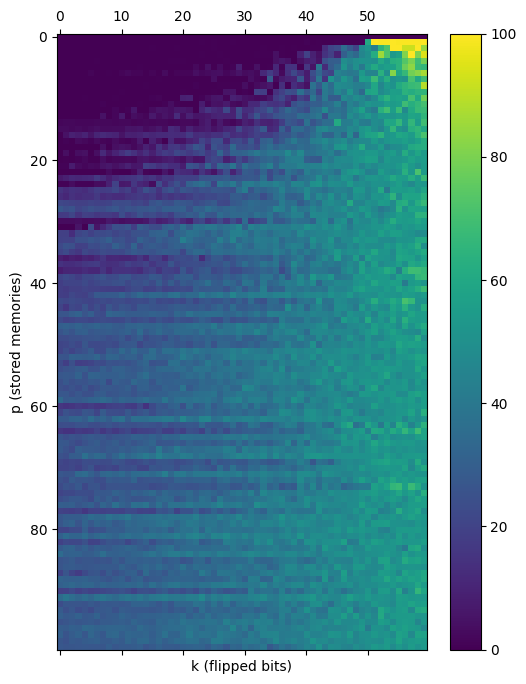

In [15]:
hamming_matrix = np.zeros((pmax, kmax))

for p in range(1, pmax):
    patterns = memories_generated(p)
    w, b = memorization_network(patterns)
    
    for k in range(kmax):
        summation = 0
        for _ in range(iterations):
            corrupted = patterns[0].copy()
            state_corruption(corrupted, k)
            
            flips = np.random.randint(0, neurons, size=1000)
            for i in range(500):
                update(corrupted, b, w, flips[i])
            
            summation += hamming_dist(patterns[0], corrupted)
        
        hamming_matrix[p, k] = summation / iterations


#plotting
fig, ax = plt.subplots(figsize=(6,8))
cax = ax.matshow(hamming_matrix, cmap='viridis')
fig.colorbar(cax)
ax.set_xlabel("k (flipped bits)")
ax.set_ylabel("p (stored memories)")
plt.show()